# SFL Small Library: HT-MEK Experimental Aggregation

In [1]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
from Bio import AlignIO
from Bio.Align import AlignInfo
import re
import ast
import sys
import copy
import itertools

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go
import plotly.express as px

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

# stats
from scipy.optimize import curve_fit
from scipy import optimize, interpolate
from scipy import stats
import scipy as scp
from scipy.stats import entropy

from itertools import groupby

# parallelization
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# file exports
import os

# import custom functions
from experiment_aggregation import aggregation

# import clear output function
from IPython.display import clear_output

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Import data

Import substrate turnover data

In [2]:
# Import Experiment for AcP Substrate
df_221022_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/221022/Interpretation/221022_AcP_workup.csv')
df_230207_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/AcP/230207_AcP_workup.csv')
df_230419_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/AcP/230419_AcP_workup.csv')
df_230410_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230410_SFL_ACYPS/Interpretation/AcP/230410_AcP_workup.csv')

# Import Experiment for ATP Substrate
df_230419_SFL_ATP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/ATP/230419_ATP_workup.csv')

# Import Experiment for PEP Substrate
df_230419_SFL_PEP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/PEP/230419_PEP_workup.csv')


# Add dfs to list of dfs
all_experiment_dfs = {'230207_AcP': df_230207_SFL_AcP,
                      '230419_AcP': df_230419_SFL_AcP,
                      '230410_AcP': df_230410_SFL_AcP,
                      '221022_AcP': df_221022_SFL_AcP,
                      '230419_ATP': df_230419_SFL_ATP,
                      '230419_PEP': df_230419_SFL_PEP
                      }

# add tags to each df
for key in all_experiment_dfs.keys():
    all_experiment_dfs[key] = aggregation.add_df_tags(all_experiment_dfs[key])

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* 

In [3]:
# # Import Experiment 2
# df_230207_SFL_DiFMUP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/DiFMUP/230207_DiFMUP_workup.csv')

# # Import Experiment 3
# df_221201_SFL_EDTA = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/221201/Craig_workup/221201_S2d2_EDTA_test.csv.bz2')

# # Import Experiment 4
# df_220608_single_muts = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/HT-MEK_expts/hACYP2/220608_hACYP2_6mutsPlusControls/220608_S2d2_Acyp2_6mutPlusControls.csv.bz2')

## Define export path

In [4]:
figure_export_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/Data_Outcomes/'

Import substrate water rate data

In [5]:
# import water rates data
df_water_rates = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230407_substrate_water_rates/Interpretation/230407_ACYP_substrate_water_rates_median.csv')

# format columns
df_water_rates['Substrate'] = df_water_rates['Condition'].str.split(' ').str[0]
df_water_rates['EDTA_Conc'] = df_water_rates['Condition'].str.split(' ').str[2].str[0]
df_water_rates = df_water_rates[df_water_rates['EDTA_Conc'] == '1']
df_water_rates = df_water_rates[['Substrate', 'Median Rate (uM/s)']]

## Initial filtering

In [6]:
# filter out chambers with low local bg ratio
for key, value in all_experiment_dfs.items():
    all_experiment_dfs[key] = all_experiment_dfs[key][all_experiment_dfs[key]['local_bg_ratio'] > 0.8]

# filter out variants with low kcat/KM R^2
for key, value in all_experiment_dfs.items():
    if 'kcat_over_KM_R2' in all_experiment_dfs[key].columns:
        all_experiment_dfs[key] = all_experiment_dfs[key][all_experiment_dfs[key]['kcat_over_KM_fit_R2'] > 0.9]

# filter out variants with very high kcat/KM values
for key, value in all_experiment_dfs.items():
    all_experiment_dfs[key] = all_experiment_dfs[key][all_experiment_dfs[key]['kcat_over_KM_fit'] < 1e6]

Plot expression

In [7]:
import itertools

# create list of combinations from dictionary
result_list = list(map(dict, itertools.combinations(
    all_experiment_dfs.items(), 2)))

for i in result_list:
    fig = aggregation.compare_replicates(dfs=i, color='x', parameter='EnzymeConc', parameter_label='Enzyme Conc (nM)', scale='linear')
    display(fig)

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_merged = pd.concat(list(dfs.values()), keys=labels, names=['Date'])
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_merged_pivot = pd.merge(df_merged_pivot, df_merged_color, on='MutantID')


/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



In [8]:
# get exponentials for each experiment
for key, value in all_experiment_dfs.items():
    if 'AcP' in key:
        all_experiment_dfs[key] = aggregation.get_exponentials(value, 10)
    elif 'ATP' in key:
        all_experiment_dfs[key] = aggregation.get_exponentials(value, 100)
    elif 'PEP' in key:
        all_experiment_dfs[key] = aggregation.get_exponentials(value, 100)

clear_output()

In [9]:
# filter out variants with low kobs R^2
for key, value in all_experiment_dfs.items():
    all_experiment_dfs[key] = value[value['Rsq_kobs'] > 0.5]

In [10]:
# remove empty dfs
for key, value in all_experiment_dfs.items():
    if len(value) == 0:
        del all_experiment_dfs[key]

# create list of combinations from dictionary
result_list = list(map(dict, itertools.combinations(
    all_experiment_dfs.items(), 2)))

for i in result_list:
    fig = aggregation.compare_replicates(dfs=i, color='local_bg_ratio', parameter='k_obs', parameter_label='k_obs (uM/s)', scale='log')
    fig.update_layout(title_text='k_obs_10uM AcP Replicates')

    # add a horizontal line at AcP water rate
    fig.add_shape(type='line',
                    x0=min(fig.data[0]['x']),
                    y0=df_water_rates[df_water_rates['Substrate'] == 'AcP']['Median Rate (uM/s)'].values[0],
                    x1=max(fig.data[0]['x']),
                    y1=df_water_rates[df_water_rates['Substrate'] == 'AcP']['Median Rate (uM/s)'].values[0],
                    line=dict(color='black', width=1, dash='dash')
                    )

    # save png
    title = '_'.join(list(i.keys()))
    fig.write_image(f'/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/SFL_progress_presentation/kobs_10uM_AcP_fit/{title}_kobs_10uM_scatter.png')
    
    display(fig)

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

Plot kcat/KM replicates and include water rate

In [11]:
# create list of combinations from dictionary
result_list = list(map(dict, itertools.combinations(
    all_experiment_dfs.items(), 2)))

for i in result_list:
    fig = aggregation.compare_replicates(dfs=i, color='Rsq_kobs', parameter='kcat_over_KM_fit', parameter_label='kcat/KM (M-1 s-1)', scale='log')
    fig.update_layout(title_text='kcat/KM AcP Replicates')
    
    # update limits
    fig.update_xaxes(range=[2, 6])
    fig.update_yaxes(range=[2, 7])

    # add a horizontal line at AcP water rate
    # fig.add_shape(type='line',
    #                 x0=min(fig.data[0]['x']),
    #                 y0=df_water_rates[df_water_rates['Substrate'] == 'AcP']['Median Rate (uM/s)'].values[0],
    #                 x1=max(fig.data[0]['x']),
    #                 y1=df_water_rates[df_water_rates['Substrate'] == 'AcP']['Median Rate (uM/s)'].values[0],
    #                 line=dict(color='black', width=1, dash='dash'),
    #                 )
 
    # save png
    title = '_'.join(list(i.keys()))
    fig.write_image(f'/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/SFL_progress_presentation/kcat_over_KM_fit/{title}_kcat_over_KM_scatter.png')
    
    
    display(fig)

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:174: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:188: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

## Plot kcat/KM for ATP

Compare AcP and ATP hydrolysis

In [12]:
def get_foldchange_df(sub1_medians, sub2_medians, ordered_substrates):

    # merge ATP and AcP medians
    kcatKM_ATP_AcP_medians = pd.merge(sub1_medians, sub2_medians, on=['MutantID', 'species', 'origin'], suffixes=(f'_{ordered_substrates[0]}', f'_{ordered_substrates[1]}'))

    # get WT rates for each species
    species = set(kcatKM_ATP_AcP_medians['species'])
    WT_rates = dict(zip(ordered_substrates, [{} for i in ordered_substrates]))

    # get WT rates for each species
    for i in ordered_substrates:
        for j in species:
            species_rates = kcatKM_ATP_AcP_medians[kcatKM_ATP_AcP_medians['species'] == j]
            if len(species_rates[species_rates['MutantID'].str.contains('wt', case=False)]) > 0:
                WT_rates[i][j] = species_rates[species_rates['MutantID'].str.contains('wt', case=False)][f'median_{i}'].values[0]

    # get fold change in rate for each species
    combined_df = kcatKM_ATP_AcP_medians
    for i in ordered_substrates:
        for j in WT_rates[i].keys():
            for index, row in combined_df.iterrows():
                if row['species'] == j:
                    combined_df.loc[index, f'foldchange_{i}'] = np.log2(row[f'median_{i}'] / WT_rates[i][j])
                else:
                    pass

    return combined_df

# 230419 experiment
AcP_medians = all_experiment_dfs['230419_AcP'].groupby(['MutantID', 'substrate', 'species', 'origin'])['kcat_over_KM_fit'].agg(['median', 'std']).reset_index()
ATP_medians = all_experiment_dfs['230419_ATP'].groupby(['MutantID', 'substrate', 'species', 'origin'])['kcat_over_KM_fit'].agg(['median', 'std']).reset_index()
PEP_medians = all_experiment_dfs['230419_PEP'].groupby(['MutantID', 'substrate', 'species', 'origin'])['kcat_over_KM_fit'].agg(['median', 'std']).reset_index()
df_foldchange_230419_AcP_ATP = get_foldchange_df(AcP_medians, ATP_medians, ordered_substrates=['AcP', 'ATP'])
df_foldchange_230419_AcP_PEP = get_foldchange_df(AcP_medians, PEP_medians, ordered_substrates=['AcP', 'PEP'])

Plot fold change in kcat/KM for each substrate from WT

In [ ]:
import seaborn as sns

# initialize figure
num_subplots = 2
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*6, 6), sharex=True, sharey=False)

def plot_foldchange(df, species, substrates_xy, ax):
    # create color palette
    origin_list = ['pross', 'progen', 'WT', 'mutant']
    palette = sns.color_palette('colorblind', len(origin_list))
    palette_dict = dict(zip(origin_list, palette))

    # plot scatter of fold change in rate in seaborn
    sns.scatterplot(data=df, x='foldchange_%s' % substrates_xy[0], y='foldchange_%s' % substrates_xy[1], 
                    hue='origin', palette=palette_dict, ax=ax, s=150)

    # add lines at x and y = 0
    ax.axhline(0, color='black', linestyle='-')
    ax.axvline(0, color='black', linestyle='-')

    # add axis labels
    ax.set_xlabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[0])
    ax.set_ylabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[1])

    # sort legend alphabetically
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = {k: by_label[k] for k in sorted(by_label, reverse=True)}
    ax.legend(by_label.values(), by_label.keys(), fancybox=True, shadow=False, title='Origin', framealpha=0.8)

    # add title
    ax.set_title('%s $k_{cat}/K_M$ fold change from WT \n 230419' % species)

# make plots
plot_foldchange(df_foldchange_230419_AcP_ATP[df_foldchange_230419_AcP_ATP['species'] == 'phorikoshii'], 'ph', ['AcP', 'ATP'], axs[0])
plot_foldchange(df_foldchange_230419_AcP_PEP[df_foldchange_230419_AcP_PEP['species'] == 'hsapiens'], 'hsapiens', ['AcP', 'PEP'], axs[1])

# tight layout
plt.tight_layout()

## Plot Covariance Matrix

In [13]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

In [14]:
# get list of sequences from align object
seq_list = []
for record in align:
    seq_list.append(record.seq)

# convert each sequence to a list of characters
seq_list = [list(i) for i in seq_list]

# convert each character to a number
for i in seq_list:
    for j in range(len(i)):
        if i[j] == 'A':
            i[j] = 0
        elif i[j] == 'C':
            i[j] = 1
        elif i[j] == 'D':
            i[j] = 2
        elif i[j] == 'E':
            i[j] = 3
        elif i[j] == 'F':
            i[j] = 4
        elif i[j] == 'G':
            i[j] = 5
        elif i[j] == 'H':
            i[j] = 6
        elif i[j] == 'I':
            i[j] = 7
        elif i[j] == 'K':
            i[j] = 8
        elif i[j] == 'L':
            i[j] = 9
        elif i[j] == 'M':
            i[j] = 10
        elif i[j] == 'N':
            i[j] = 11
        elif i[j] == 'P':
            i[j] = 12
        elif i[j] == 'Q':
            i[j] = 13
        elif i[j] == 'R':
            i[j] = 14
        elif i[j] == 'S':
            i[j] = 15
        elif i[j] == 'T':
            i[j] = 16
        elif i[j] == 'V':
            i[j] = 17
        elif i[j] == 'W':
            i[j] = 18
        elif i[j] == 'Y':
            i[j] = 19
        else:
            i[j] = 20

De-gap the alignment

In [15]:
# delete column if it contains more than 50% gaps
frames = np.asarray(seq_list)
frames = np.delete(frames, np.where((frames == 20).sum(axis=0) > 0.9*len(frames)), axis=1)

Text(0, 0.5, 'Normed Covariance')

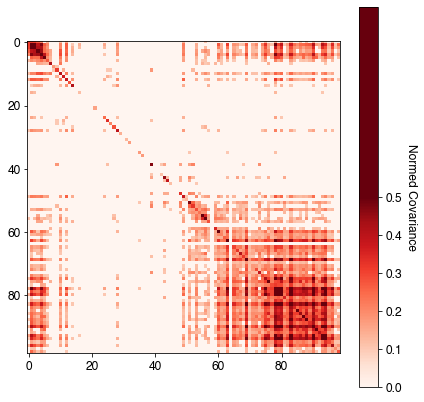

In [16]:
covar = np.cov(frames, rowvar=False)

# increase figure size
plt.rcParams['figure.figsize'] = [7, 7]

# normalize covariance matrix
covar = covar / np.max(covar)

# shrink values below 0.6 to 0
covar[covar < 0.1] = 0

# plot covariance matrix as scatter plot
plt.imshow(covar, cmap='Reds', interpolation='nearest')

# create colorbar and change normalization range
cbar = plt.colorbar()
cbar.norm.vmax = 0.5

# add label to cbar
cbar.ax.set_ylabel('Normed Covariance', rotation=270, labelpad=15)

Format indices for data

In [ ]:
# define a regular expression to match numbers in the range 0-10
pattern = r"\{(0\d|\d),(0\d|\d)\}"

# The replacement string to use in the string replace operation
# It includes a leading zero for single-digit numbers and removes the curly brackets
replacement = r"0\1,0\2"

# Apply the string replace operation to each element in the column using the re.sub() function
df_221201_SFL["Indices"] = df_221201_SFL["Indices"].apply(lambda x: re.sub(pattern, replacement, x))

For 221022, format names and merge sequence information with data

In [ ]:
# import protein sequences
full_protein_sequence_library = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/all-sequences-library.csv')

# import DNA sequences
full_DNA_sequence_library = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/1_Final_Order/full-optimized-oligo-library.xlsx')
full_DNA_sequence_library = full_DNA_sequence_library[['name', 'dna_sequence', 'oligo_len', 'average_ecoli_usage']]

# import single mutant log likelihoods
single_mutant_likelihoods = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/micah-single-mutant-seqs-022723.csv')

# format each
full_protein_sequence_library = aggregation.add_df_tags(full_protein_sequence_library)
full_DNA_sequence_library = aggregation.add_df_tags(full_DNA_sequence_library)
df_230207_SFL = aggregation.add_df_tags(df_230207_SFL)

In [ ]:
# manual egfp culling
df_221022_SFL = df_221022_SFL[df_221022_SFL['egfp_manual_flag'] == False]

# remove well position from name
df_221022_SFL['name'] = df_221022_SFL['MutantID'].str.split(r'(^\d{1,}\w{0,1}\d{1,}_)', expand=True)[2] # remove well number

# finally, merge the expression and full_sequence_library DataFrames
df_221022_SFL_merge = pd.merge(df_221022_SFL, full_protein_sequence_library[['name', 'protein_sequence', 'species',	'origin',	'sampling_replicate',	'lambda',	'seq_id', 'ensemble_ll', 'predicted_tm', 'n_mutations']], on='name')

# reduce to only a single row per chamber and add mutation chamber for single mutants
df_221022_SFL_merge = df_221022_SFL_merge.drop_duplicates(subset=['x', 'y'], keep='first').sort_values(by=['x', 'y'])
df_221022_SFL_merge['mutation'] = df_221022_SFL_merge.name.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)

# WT df
WT_df = df_221022_SFL_merge[df_221022_SFL_merge['origin'] == 'WT']

# add wt sequence to each row
df_221022_SFL_merge = pd.merge(df_221022_SFL_merge, WT_df[['species', 'protein_sequence']], on='species', suffixes=['', '_wt'])

For 230207, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_230207_SFL = df_230207_SFL[df_230207_SFL['egfp_manual_flag'] == False]

# merge the expression and full_sequence_library DataFrames
df_230207_SFL_merge = pd.merge(df_230207_SFL, full_protein_sequence_library, on=list(set(df_230207_SFL.columns).intersection(set(full_protein_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, full_DNA_sequence_library, on=list(set(df_230207_SFL_merge.columns).intersection(set(full_DNA_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, single_mutant_likelihoods, on=['mutation', 'protein_sequence'], how='outer')
df_230207_SFL_merge = df_230207_SFL_merge.fillna('')

# remove redundant rows for each chamber
df_230207_SFL_merge = df_230207_SFL_merge.drop_duplicates(subset='Indices')


In [ ]:
df_230207_SFL_merge

For 220608, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_220608_single_muts = df_220608_single_muts[df_220608_single_muts['ManualGFPFlag'] == 0]

# reduce to only a single row per chamber and add mutation column
df_220608_single_muts_merge = df_220608_single_muts[df_220608_single_muts['SubstrateConc'] == 10][['Indices', 'MutantID', 'fit_mm_kcatoverKM_MMfit', 'EnzymeConc', 'LocalBackgroundRatio']]

# add mutation column
df_220608_single_muts_merge['mutation'] = df_220608_single_muts_merge.MutantID.str.extract(r'([A-Z]\d{0,2}[A-Z])', expand=False).fillna('')

Export 230207 df

In [ ]:
df_230207_SFL_merge.drop_duplicates(subset='Indices')[['Indices', 'MutantID',
       'EnzymeConc', 'egfp_manual_flag', 
       'summed_button_BGsub_Button_Quant', 'GlobalExperimentIndex', 'Experiment', 'name',
       'protein_sequence', 'species', 'origin', 'sampling_replicate', 'lambda',
       'seq_id', 'ensemble_ll', 'predicted_tm', 'n_mutations', 'mutation',
       'protein_sequence_wt', 'average_ecoli_usage', 'dna_sequence']].to_csv('/Users/micaholivas/Downloads/230207_SFL_expression_with_DNA_sequence.csv')

## Count library members

In [ ]:
set(df_230207_SFL_merge.species)

In [ ]:
df_230207_SFL_merge.drop_duplicates(subset='MutantID').groupby(["species", "origin"]).size()

In [ ]:
# remove flagged chambers
dat = df_230207_SFL[df_230207_SFL['egfp_manual_flag'] == False]
dat = dat[dat['x'] > 16]
dat_blank = dat[dat['MutantID'] == 'BLANK']
print(dat_blank[['MutantID', 'summed_button_BGsub_Button_Quant']].quantile(0.85))

# Pre-filter Plotting

## Expression

### Experiment summaries

In [ ]:
def plot_pie_chart(series, title=None, ax=None):
    expression_outcomes = list(series.to_dict().keys())
    data = list(series.to_dict().values())

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-10, colors=['goldenrod', 'darkslateblue'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    ax.set_title(title)

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(expression_outcomes[i] + '\n' + str(data[i]) + ' chambers', xy=(x, y), xytext=(1.01*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
                

In [ ]:
all_blanks

In [ ]:
import matplotlib.patheffects as PathEffects

fig, axs = plt.subplots(2, 4, figsize=(17,7), facecolor='white')

### 102222
# remove blank chambers
all_blanks = df_221022_SFL[df_221022_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_221022_SFL[df_221022_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')

# plot histograms
axs[0, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[0, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[0, 0].set_xlabel('eGFP Concentration (uM)')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_title('10/22/22 \n Expression')
# axs[0, 0].ticklabel_format(style='plain')

counts = df_221022_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, title='PROSS', ax=axs[0, 1])
plot_pie_chart(s_progen, title='ProGen2', ax=axs[0, 2])
plot_pie_chart(s_WT, title='WT', ax=axs[0, 3])

### 230207
# remove blank chambers
all_blanks = df_230207_SFL[df_230207_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_230207_SFL[df_230207_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_blanks = all_blanks[all_blanks['x'] < 16]
all_library = all_library[all_library['x'] < 16]

# plot histograms
axs[1, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[1, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[1, 0].set_xlabel('eGFP Concentration (uM)')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_title('02/07/23 \n Right Side Expression')
# axs[1, 0].ticklabel_format(style='plain')

counts = df_230207_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, ax=axs[1, 1])
plot_pie_chart(s_progen, ax=axs[1, 2])
plot_pie_chart(s_WT, ax=axs[1, 3])

axs[1, 1].set_title('PROSS')
axs[1, 2].set_title('ProGen2')
axs[1, 3].set_title('WT')

plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
fig.savefig(current_export_directory + "summary_expression_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_expression_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

## Scatter of expression vs number of mutations

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True, facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

df_230207_SFL_merge.plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[0], alpha=0.4)
ax[0].set_xlabel('Number of Mutations \n Relative to WT')
ax[0].set_ylabel('Enzyme \n Concentration (nM)')
ax[0].set_title('230207 Expt')

df_221022_SFL_merge.drop_duplicates(subset='Indices').plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[1], alpha=0.4)
ax[1].set_xlabel('Number of Mutations \n Relative to WT')
ax[1].set_ylabel('')
ax[1].set_title('221022 Expt')


plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/expression/sequence_identity/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v1'
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 

### Device Heatmap

In [ ]:
### 221022
# df_221022_SFL = df_221022_SFL[(df_221022_SFL['local_bg_ratio'] < 70) & (df_221022_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_221022 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_221022['substrate_concs'] = squeeze_mm_221022['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_221022['lbg_ratio'] = squeeze_mm_221022['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

### 230207
# df_230207_SFL = df_230207_SFL[(df_230207_SFL['local_bg_ratio'] < 70) & (df_230207_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_230207 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_230207['substrate_concs'] = squeeze_mm_230207['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_230207['lbg_ratio'] = squeeze_mm_230207['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

# now, save substrate concs
all_substrate_concs = squeeze_mm_230207['substrate_concs'][0]

squeeze_mm_230207

In [ ]:
def heatmap(data, ax=None, fig=None, norm=None, cmap=None, vmin=None, vcenter=None, vmax=None,
            cbar_kw=None, cbarlabel="", display_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    # if ax is None:
    #     ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # create vcenter if None provided
    if vcenter == None:
        vcenter = (vmax - vmin)/2

    # PCM method
    divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    pcm = ax.pcolormesh(data, cmap=cmap, norm=divnorm)

    # Create colorbar
    if display_cbar == True:
        cbar = fig.colorbar(pcm, ax=ax, norm=mpl.colors.Normalize(vmin=0, vmax=20), **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.tick_params(which="minor", bottom=False, left=False)

    return pcm, cbar

In [ ]:
parameter = 'enzyme_conc'

fig, axs = plt.subplots(2,2, figsize=(10,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.5)


### 221022
grid = squeeze_mm_221022.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[0, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[0, 0].set_xlabel("Column")
axs[0, 0].set_ylabel("Row")
axs[0, 0].set_title("10/22/22 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[0, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig                    
                    )
axs[0, 1].set_xlabel("Column")
axs[0, 1].set_ylabel("Row")
axs[0, 1].set_title("10/22/22 Experiment")


### 230207
grid = squeeze_mm_230207.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[1, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[1, 0].set_xlabel("Column")
axs[1, 0].set_ylabel("Row")
axs[1, 0].set_title("02/07/23 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[1, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig
                    )
axs[1, 1].set_xlabel("Column")
axs[1, 1].set_ylabel("Row")
axs[1, 1].set_title("02/07/23 Experiment")

# define export directory
current_export_directory = figure_export_path + '/aggregated/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + '/heatmap_SFL_%s.png' % (version), bbox_inches = 'tight')
plt.savefig(current_export_directory + '/heatmap_SFL_%s.svg' % (version), bbox_inches = 'tight')

# Filtering

### Filtering by local bg ratio cutoff

In [ ]:
enz_conc_threshold = 5
lbgr_threshold = 2
kcat_over_KM_upper_threshold = 200000

df_230207_SFL.loc[df_230207_SFL.local_bg_ratio < lbgr_threshold, 'kinetic_limit'] = 'upper'
df_230207_SFL.loc[df_230207_SFL.local_bg_ratio > lbgr_threshold, 'kinetic_limit'] = 'none'
df_230207_SFL = df_230207_SFL[df_230207_SFL['kcat_over_KM_fit']  < kcat_over_KM_upper_threshold ]
df_230207_SFL = df_230207_SFL[df_230207_SFL['EnzymeConc'] > enz_conc_threshold]

df_221022_SFL.loc[df_221022_SFL.local_bg_ratio < lbgr_threshold, 'kinetic_limit'] = 'upper'
df_221022_SFL.loc[df_221022_SFL.local_bg_ratio > lbgr_threshold, 'kinetic_limit'] = 'none'
df_221022_SFL = df_221022_SFL[df_221022_SFL['kcat_over_KM_fit'] < kcat_over_KM_upper_threshold ]
df_221022_SFL = df_221022_SFL[df_221022_SFL['EnzymeConc'] > enz_conc_threshold]

df_230207_SFL_merge.loc[df_230207_SFL_merge.local_bg_ratio < lbgr_threshold, 'kinetic_limit'] = 'upper'
df_230207_SFL_merge.loc[df_230207_SFL_merge.local_bg_ratio > lbgr_threshold, 'kinetic_limit'] = 'none'
df_230207_SFL_merge = df_230207_SFL_merge[df_230207_SFL_merge['kcat_over_KM_fit'] < kcat_over_KM_upper_threshold ]
df_230207_SFL_merge = df_230207_SFL_merge[df_230207_SFL_merge['EnzymeConc'] > enz_conc_threshold]

df_221022_SFL_merge.loc[df_221022_SFL_merge.local_bg_ratio < lbgr_threshold, 'kinetic_limit'] = 'upper'
df_221022_SFL_merge.loc[df_221022_SFL_merge.local_bg_ratio > lbgr_threshold, 'kinetic_limit'] = 'none'
df_221022_SFL_merge = df_221022_SFL_merge[df_221022_SFL_merge['kcat_over_KM_fit'] < kcat_over_KM_upper_threshold ]
df_221022_SFL_merge = df_221022_SFL_merge[df_221022_SFL_merge['EnzymeConc'] > enz_conc_threshold]

df_220608_single_muts_merge = df_220608_single_muts_merge[df_220608_single_muts_merge['LocalBackgroundRatio'] > lbgr_threshold]
df_220608_single_muts_merge = df_220608_single_muts_merge[df_220608_single_muts_merge['EnzymeConc'] > enz_conc_threshold]

In [ ]:
df_230207_SFL[df_230207_SFL['MutantID'].str.contains('cons')][['MutantID', 'EnzymeConc', 'kcat_over_KM_fit', 'kinetic_limit', 'local_bg_ratio']].head(50)

## Calculate kcat/KM from k_obs

In [ ]:
import ast

# select only 10 uM conditions
df_10_uM = df_230207_SFL[df_230207_SFL['substrate_conc_uM'] == 10]

# select random chamber
n = np.random.randint(0, 800)

# get data
xdata = ast.literal_eval(df_10_uM.iloc[n].time_s)
ydata = ast.literal_eval(df_10_uM.iloc[n].kinetic_product_concentration_uM)

# define exponential function amd vectorize
def exponential(t, A, k, y0): 
    return A*(1-np.exp(-k*t))+y0
v_exponential = np.vectorize(exponential)

# fit exponential to data
# excluded high concentration
def exponential_fit(xdata, ydata):
    popt, pcov = optimize.curve_fit(exponential, xdata, ydata, bounds=([0, 0, 0], [np.inf, 0.05, np.inf])) # A, k, y_0
    return popt

popt = exponential_fit(xdata, ydata) # A, k, y0

linx = np.linspace(0, 4000, 300)

plt.scatter(x=xdata, y=ydata, label='data')
plt.plot(linx, v_exponential(linx, *popt), 'g--', label='fit')
plt.xlabel('Time (s)')
plt.ylabel('[Product] (uM)')
plt.title('10 uM Condition \n Chamber: ' + df_10_uM.iloc[n].Indices)
plt.legend()

In [ ]:
import ast

def fit_kobs_exponential(df):
    # store data
    indices = df.Indices
    xdata = ast.literal_eval(df.time_s)
    ydata = ast.literal_eval(df.kinetic_product_concentration_uM)

    # define exponential function amd vectorize
    def exponential(t, A, k, y0): 
        return A*(1-np.exp(-k*t))+y0
    v_exponential = np.vectorize(exponential)

    # fit exponential to data
    # excluded high concentration
    def exponential_fit(xdata, ydata):
        try:
            popt, pcov = optimize.curve_fit(exponential, xdata, ydata, bounds=([0, 0, 0], [np.inf, 0.01, np.inf])) # A, k, y_0
        except Exception:
            popt = [np.nan, np.nan, np.nan]
        return popt

    popt = exponential_fit(xdata, ydata) # A, k, y0

    k_fit = popt[1] # this rate is in uM per second
    kcat_over_KM_estimate = k_fit * 10000000 # M^-1 s^-1

    return kcat_over_KM_estimate

# apply function and store fit parameters
results = df_230207_SFL_merge.apply(fit_kobs_exponential, axis=1)
df_230207_SFL_merge['kobs_exp_fit'] = results.apply(lambda x: x)

# # apply function and store fit parameters
# results = df_221022_SFL_merge.apply(fit_kobs_exponential, axis=1)
# df_221022_SFL_merge['kobs_exp_fit'] = results.apply(lambda x: x)

# Compare kcat/KM vs [E]

For df_221022_SFL

In [ ]:
df_221022_SFL_chamber_summary = df_221022_SFL_merge.drop_duplicates(subset=['MutantID', 'Indices'], keep='last').sort_values(by=['x', 'y'])
df_230207_SFL_chamber_summary = df_230207_SFL_merge.drop_duplicates(subset=['MutantID', 'Indices'], keep='last').sort_values(by=['x', 'y'])

Check to see if there is a relationship between kcat/KM and eGFP concentration

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,5), sharey=True, facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

df_221022_SFL_chamber_summary.plot.scatter(x='EnzymeConc', y='kcat_over_KM_fit', ax=ax[0], alpha=0.4)
ax[0].set_xlabel('Enzyme \n Concentration (nM)')
ax[0].set_ylabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$)')
ax[0].set_title('221022 Expt')

df_230207_SFL_chamber_summary.plot.scatter(x='EnzymeConc', y='kcat_over_KM_fit', ax=ax[1], alpha=0.4)
ax[1].set_xlabel('Enzyme \n Concentration (nM)')
ax[1].set_ylabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$)')
ax[1].set_title('230207 Expt')

fig.suptitle('$k_{cat}/K_M$ from MM fit')
plt.tight_layout()

version = 'v1'
plt.savefig(figure_export_path + 'kcat_over_KM_vs_expression_SFL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(figure_export_path + 'kcat_over_KM_vs_expression_SFL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

## Plot sample MM curves

In [ ]:
# init example mutants
all_muts = [
        'hsapiens2_V20A', #
        'hsapiens2_E29D', #
        # 'hsapiens2_G45A', #
        # 'hsapiens2_Y25A',
        # 'hsapiens2_E83D',
        # 'hsapiens2_V17A',
        # 'hsapiens2_V9A',
        # 'hsapiens2_L89A',
        # 'hsapiens2_V35A',
        # 'hsapiens2_C21S',
        # 'hsapiens2_R97A',
        # 'hsapiens2_R23A',
        # 'hsapiens2_N41Q',
        # 'hsapiens2_N41A',
        # 'hsapiens2_I86V',
        # 'hsapiens2_F94L',
        # 'hsapiens2_Y11I',
        # 'hsapiens2_V13A',
        # 'hsapiens2_F22L',
        # 'hsapiens2_T42A',
        'hsapiens2_V47A',
        # 'hsapiens2_Y11F',
        # 'hsapiens2_wt',
        ]

chamber_df = df_230207_SFL.drop_duplicates(subset='Indices')
chamber_df = chamber_df[chamber_df['local_bg_ratio'] > .9]
chamber_df = chamber_df[chamber_df['EnzymeConc'] > 20]
picks = set(chamber_df[chamber_df['name'].isin(all_muts)]['name'])
chamber_df[chamber_df['name'].isin(picks)][['name', 'Indices', 'EnzymeConc', 'kcat_over_KM_fit', 'local_bg_ratio', 'initial_rates', 'substrate_concs']].sort_values(by='name')

In [ ]:
from matplotlib.lines import Line2D

# init MM func
def mm_func(S, Km, Vmax): 
    return Vmax*S/(Km+S)
vfunc = np.vectorize(mm_func)

# init color dictionary
color_dict = dict(zip(picks, range(len(picks))))

# create custom legend handles
legend_elements = []

# init figure
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

# plot sample curves
for i in picks:
    

    mut_df = chamber_df[chamber_df['name'] == i]
    
    for index, row in mut_df.iterrows():
        xdata = np.array(ast.literal_eval(row['substrate_concs']))
        ydata = np.array(ast.literal_eval(row['initial_rates']))/row['EnzymeConc']
        
        KM_fit = float(row['KM_fit'])
        vmax_fit = float(row['vmax_fit'])/row['EnzymeConc']
                                 
        # plot scatter
        axs.scatter(x=xdata[1:], y=ydata[1:], color='C'+str(color_dict[i]), s=70, alpha=0.6)

        # plot MM curves
        t = np.linspace(0, 75, 500)
        axs.plot(t, vfunc(t, *[KM_fit, vmax_fit]), '--', color='C'+str(color_dict[i]), alpha=0.5)

    # add handle to legend elements
    legend_elements.append(Line2D([0], [0], marker='o', color='C'+str(color_dict[i]), label=i.split('_')[-1].upper()))

axs.set_ylabel('Normalized Initial Rate ($v_i$ $[E]^{-1}$)')
axs.set_xlabel('[Substrate]')
axs.legend(handles=legend_elements, fancybox=True, shadow=True)#, loc='center left', bbox_to_anchor=(1, 0.5))

# define export directory
current_export_directory = figure_export_path + '/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v1'
plt.savefig(current_export_directory + 'sample_MM_curves_single_muts_SFL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'sample_MM_curves_single_muts_SFL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 



# kcat/KM scatterplots

In [ ]:
df_221022_SFL_kcatKM_means = df_221022_SFL_chamber_summary[['MutantID', 'kcat_over_KM_fit', 'GlobalExperimentIndex']].groupby('MutantID').agg(['mean', 'std'])
df_230207_SFL_kcatKM_means = df_230207_SFL_chamber_summary[['MutantID', 'kcat_over_KM_fit', 'GlobalExperimentIndex']].groupby('MutantID').agg(['mean', 'std'])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

combined_kcat_over_KM_fit = pd.merge(left=df_221022_SFL_kcatKM_means, right=df_230207_SFL_kcatKM_means, on=['MutantID'], suffixes=['_221022', '_230207']).drop_duplicates()

# plot kcat/KM from MM fit
axs[0].scatter(x=combined_kcat_over_KM_fit['kcat_over_KM_fit_221022']['mean'], y=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['mean'], alpha=0.5, label='Library Member')
axs[0].errorbar(x=combined_kcat_over_KM_fit['kcat_over_KM_fit_221022']['mean'], 
                y=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['mean'], 
                xerr=combined_kcat_over_KM_fit['kcat_over_KM_fit_221022']['std'], 
                yerr=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['std'], 
                fmt='o', 
                alpha=0.4
                )
axs[0].set_xlabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n 221022 Experiment')
axs[0].set_ylabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n 230207 Experiment')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
lim = axs[0].get_xlim()
axs[0].set_xlim(lim[0]*0.2, lim[1]*1.2)
axs[0].set_ylim(lim[0]*0.2, lim[1]*1.2)
lim = axs[0].get_xlim()
axs[0].plot([lim[0], lim[1]], [lim[0], lim[1]], '--', label='VEL')
axs[0].legend(loc='best')
axs[0].set_title('02/07/23 vs 10/22/22 \n MM Fit $k_{cat}/K_M$')

# plot k_obs
k_obs_10 = df_230207_SFL_merge[df_230207_SFL_merge['substrate_conc_uM'] == 10]
k_obs_10_means = k_obs_10[['MutantID', 'Indices', 'kobs_exp_fit', 'kcat_over_KM_fit']].groupby('MutantID').agg(['mean', 'std'])
axs[1].scatter(x=k_obs_10_means['kcat_over_KM_fit']['mean'], y=k_obs_10_means['kobs_exp_fit']['mean'], alpha=0.5)
axs[1].errorbar(x=k_obs_10_means['kcat_over_KM_fit']['mean'], y=k_obs_10_means['kobs_exp_fit']['mean'], xerr=k_obs_10_means['kcat_over_KM_fit']['std'], yerr=k_obs_10_means['kobs_exp_fit']['std'], fmt='o', alpha=0.6)
axs[1].set_xlabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n from MM fit')
axs[1].set_ylabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n from exponential fit')
lim = axs[1].get_xlim()
axs[1].plot([lim[0], lim[1]], [lim[0], lim[1]], '--', label='VEL')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend(loc='best')
axs[1].set_title('02/07/23 \n MM Fit vs exp fit \n $k_{cat}/K_M$')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/aggregated/kcat_over_KM/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v2'
plt.savefig(current_export_directory + 'kcat_over_KM_equivalence_SFL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'kcat_over_KM_equivalence_SFL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 

## kcat/KM by construct: box and whisker plot

Define lit and past expt's

In [ ]:
C21S = 14000
T42A = 12700

benzoyl_phosphate_pKa = 4.19
acetyl_phosphate_pKa = 4.75

lfer_slope = -1.4439572688424076


lit_vals_muts = {13: acetyl_phosphate_pKa*(T42A/benzoyl_phosphate_pKa), 3: acetyl_phosphate_pKa*(C21S/benzoyl_phosphate_pKa)}
expt_220405 = {13:10445.332, 3: 36072.06, 7: 11487.432, 11: 104298.180, 14: 30616.233}

In [ ]:
set(df_230207_SFL_merge.species)

In [ ]:
parameter = 'kcat_over_KM_fit'
species = 'consensus'
description = '$k_{cat}/K_M$ ($M^{-1} s^{-1}$)'
expt_date = '230207'
# description = 'designs'

expression_230207 = df_230207_SFL_merge[(df_230207_SFL_merge['species'] == species)]
expression_221022 = df_221022_SFL_merge[(df_221022_SFL_merge['species'] == species)]

box_df = globals()['expression_' + expt_date][['origin', 'sampling_replicate', 'species', parameter, 'lambda', 'seq_id', 'mutation', 'kinetic_limit']]

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + 0.1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    label_d = dict(zip(df.index.names[::-1], range(df.index.nlevels)[::-1]))
    for k, level in label_d.items():
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes) # add primary label
            ax.text(0, ypos, k + ':  ', ha='right', transform=ax.transAxes) # add level label to left
            # add_line(ax, pos*scale, ypos)

            # if the current level is the highest in the hierarchy, add additional lines 
            # to connect that level's dividers up to the x-axis line
            if level == 0:
                for i in label_d.values():
                    add_line(ax, pos * scale , ypos + i/10)
            else:
                add_line(ax, pos * scale , ypos)

            pos += rpos
        ypos -= 0.1



### FIRST PLOT
# box_df = box_df[(box_df['species'] == species) & (box_df['origin'] == 'progen') & (box_df['origin'] != 'pross')] 
df = box_df.groupby(['species', 'origin', 'lambda', 'seq_id', 'sampling_replicate', 'mutation'])
df_indices = box_df.groupby(['species', 'origin', 'lambda', 'seq_id', 'sampling_replicate', 'mutation']).median()
fig = plt.figure(figsize=(25, 15))

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)

ax = fig.add_subplot(111)

# plot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='k')

df.boxplot(subplots=False, 
           ax=fig.gca(), 
           grid=False,
           boxprops=boxprops,
           medianprops=medianprops
           )

# plot points
for g_index, g_row in enumerate(df):
    for index, row in g_row[1].iterrows():
        y = row[parameter]
        x = [g_index+1]

        # plot non-limits
        if row['kinetic_limit'] == 'none':
            ax.plot(x, y, mec='k', ms=7, marker="o", linestyle="None")
        
        # plot limits
        elif row['kinetic_limit'] == 'upper':
            ax.plot(x, y, mec='k', ms=20, marker="x", linestyle="None")

# ax.plot(list(lit_vals_muts.keys()), list(lit_vals_muts.values()), marker='+', label='Literature', mec='k', ms=10, linestyle="None")
# ax.plot(list(expt_220405.keys()), list(expt_220405.values()), marker='^', label='220405 Expt', mec='k', ms=15, linestyle="None")
# ax.legend()

#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.set_ylabel(description)
ax.set_yscale('log')
ax.set_title('  /  '.join([parameter, species, expt_date]), loc='left')

# hide zero y-axis label
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

label_group_bar_table(ax, df_indices)

fig.subplots_adjust(bottom = .1 * df_indices.index.nlevels)
fig.set_facecolor('white')

# define export directory
current_export_directory = figure_export_path + 'by_construct/' + expt_date + '/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

# version = 'v2'
# plt.savefig(current_export_directory + '/%s_%s_by_construct_%s_%s_%s.png' % (expt_date, parameter, species, description, version), dpi=300, transparent=False, bbox_inches='tight') 
# plt.savefig(current_export_directory + '/%s_%s_by_construct_%s_%s_%s.svg' % (expt_date, parameter, species, description, version), dpi=300, transparent=False, bbox_inches='tight') 

plt.show()

## kcat/KM single mutant references scatterplot

Before proceeding, we should filter low local bg ratio points from this dataset

In [ ]:
df_220608_single_muts = df_220608_single_muts[df_220608_single_muts['LocalBackgroundRatio'] > 2]
df_221022_SFL = df_221022_SFL[df_221022_SFL['local_bg_ratio'] > 2]

First, compare rates between single mutants in 10/22/22 SFL experiment and past single mutant experiment

In [ ]:
# define the mutant regex
mut_reg = r'([A-Z][0-9]+[A-Z])'

# process the single muts data
df_220608_kcat_over_KM = df_220608_single_muts[['MutantID','fit_mm_kcatoverKM_MMfit', 'LocalBackgroundRatio']].drop_duplicates()
df_220608_kcat_over_KM['aa_substitution'] = df_220608_kcat_over_KM['MutantID'].str.extract(mut_reg, expand=False).str.strip()
df_220608_kcat_over_KM = df_220608_kcat_over_KM[df_220608_kcat_over_KM['aa_substitution'].notna()]  # drop others
df_220608_kcat_over_KM = df_220608_kcat_over_KM.groupby('aa_substitution').mean().reset_index()
df_220608_kcat_over_KM = df_220608_kcat_over_KM.replace('R98A', 'R97A')
df_220608_kcat_over_KM['fit_mm_kcatoverKM_MMfit'] = df_220608_kcat_over_KM['fit_mm_kcatoverKM_MMfit']/10**2

# process the SFL data
df_230207_SFL_kcat_over_KM = df_230207_SFL[['MutantID','kcat_over_KM_fit']].drop_duplicates()
df_230207_SFL_kcat_over_KM['aa_substitution'] = df_230207_SFL_kcat_over_KM['MutantID'].str.extract(mut_reg, expand=False).str.strip()
df_230207_SFL_kcat_over_KM = df_230207_SFL_kcat_over_KM[df_230207_SFL_kcat_over_KM['aa_substitution'].notna()] # drop others
df_230207_SFL_kcat_over_KM = df_230207_SFL_kcat_over_KM.groupby('aa_substitution').mean().reset_index()

# merge data
pd.merge(df_220608_kcat_over_KM[['aa_substitution', 'fit_mm_kcatoverKM_MMfit']], df_230207_SFL_kcat_over_KM[['aa_substitution', 'kcat_over_KM_fit']], on="aa_substitution")

Now, plot kcat_over_KM for combined

In [ ]:
terms = ['fit_mm_kcatoverKM_MMfit', 'EnzymeConc', 'MutantID', 'GlobalExperimentIndex', 'x', 'y']

combined = pd.merge(df_230207_SFL[['kcat_over_KM_fit', 'EnzymeConc', 'MutantID', 'GlobalExperimentIndex', 'x', 'y']], df_221201_SFL[terms], on=['MutantID', 'x', 'y']).drop_duplicates()
combined

In [ ]:
df_230207_SFL_kcat_over_KM_means = df_230207_SFL_chamber_summary[['MutantID', 'kcat_over_KM_fit', 'GlobalExperimentIndex', 'species', 'origin']].groupby(['MutantID', 'species', 'origin'], as_index=False).agg(['mean', 'std']).reset_index()

In [ ]:
df_230207_SFL_kcatKM_means = df_230207_SFL_chamber_summary[['MutantID', 'kcat_over_KM_fit', 'GlobalExperimentIndex', 'mutation']].groupby('mutation').agg(['mean', 'std'])
df_220608_single_muts_kcatKM_means = df_220608_single_muts_merge[['MutantID', 'fit_mm_kcatoverKM_MMfit', 'mutation']].groupby('mutation').agg(['mean', 'std'])


In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 7), facecolor='white')
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

# font = {'family' : 'helvetica',
#         'weight' : 'normal',
#         'size'   : 18}

# mpl.rc('font', **font)

# combined_kcat_over_KM_fit = pd.merge(left=df_230207_SFL_kcatKM_means, right=df_220608_single_muts_kcatKM_means, on=['mutation'], suffixes=['_230207', '_220608']).drop_duplicates()

# # plot kcat/KM from MM fit
# axs[0].scatter(x=combined_kcat_over_KM_fit['kcat_over_KM_fit_220608']['mean'], y=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['mean'], alpha=0.5, label='Library Member')
# axs[0].errorbar(x=combined_kcat_over_KM_fit['kcat_over_KM_fit_220608']['mean'], 
#                 y=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['mean'], 
#                 xerr=combined_kcat_over_KM_fit['kcat_over_KM_fit_220608']['std'], 
#                 yerr=combined_kcat_over_KM_fit['kcat_over_KM_fit_230207']['std'], 
#                 fmt='o', 
#                 alpha=0.4
#                 )
# axs[0].set_xlabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n 220608 Experiment')
# axs[0].set_ylabel('$k_{cat}/K_M$ ($M^{-1} s^{-1}$) \n 230207 Experiment')
# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# lim = axs[0].get_xlim()
# axs[0].set_xlim(lim[0]*0.2, lim[1]*1.2)
# axs[0].set_ylim(lim[0]*0.2, lim[1]*1.2)
# lim = axs[0].get_xlim()
# axs[0].plot([lim[0], lim[1]], [lim[0], lim[1]], '--', label='VEL')
# axs[0].legend(loc='best')
# axs[0].set_title('02/07/23 vs 06/08/22 \n MM Fit $k_{cat}/K_M$')

# plt.tight_layout()

# # define export directory
# current_export_directory = figure_export_path + '/aggregated/kcat_over_KM/'

# if not os.path.exists(current_export_directory):
#     os.makedirs(current_export_directory)

# version = 'v2'
# plt.savefig(current_export_directory + 'kcat_over_KM_SFL_vs_reference_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
# plt.savefig(current_export_directory + 'kcat_over_KM_SFL_vs_reference_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 

## EDTA Comparison

In [ ]:
df_221201_SFL[df_221201_SFL['series_index'] == '25uM_AcP_1'][terms]

In [ ]:
# select only terms of interest
terms = ['x', 'y', 'MutantID', 'OptLinFitSlope']

# filter the full dataset for only the 25 uM AcP condition
pre_EDTA = df_221201_SFL_EDTA[df_221201_SFL_EDTA['series_index'] == '25uM_AcP_noEDTA'][terms]
post_EDTA = df_221201_SFL_EDTA[df_221201_SFL_EDTA['series_index'] == '25uM_AcP_1mM_EDTA'][terms]

# finally, merge these data
merged_EDTA = pd.merge(left=pre_EDTA, right=post_EDTA, on=['x', 'y', 'MutantID'], suffixes=('_preEDTA', '_postEDTA'))

In [ ]:
# convert slope to fold-change
merged_EDTA['Fold_change_preEDTA'] = merged_EDTA.OptLinFitSlope_preEDTA/merged_EDTA.OptLinFitSlope_preEDTA
merged_EDTA['Fold_change_postEDTA'] = merged_EDTA.OptLinFitSlope_postEDTA/merged_EDTA.OptLinFitSlope_preEDTA
merged_EDTA[['x', 'y', 'MutantID', 'Fold_change_preEDTA', 'Fold_change_postEDTA']]


In [ ]:
merged_EDTA = merged_EDTA[(merged_EDTA['Fold_change_postEDTA'] <= 1) & (merged_EDTA['Fold_change_postEDTA'] > 0)]

boxplot = merged_EDTA.boxplot(column=['Fold_change_preEDTA', 'Fold_change_postEDTA'], showfliers=True)

# Export seqs for Alphafold

# Stability Data

First, process the data

In [ ]:
# filter by expression
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP[df_230207_SFL_DiFMUP['EnzymeConc'] > 5]

# filter for single row per chamber
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['local_bg_ratio_x'] > 2.5]

# filter for single row per chamber
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['urea_conc_mM'] == 0]

# filter no egfp flag
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['egfp_manual_flag'] == False]

# subset columns
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[['Indices', 'MutantID', 'EnzymeConc', 'two_point_fit', 'rate_fit_regime',
       'egfp_manual_flag', 'urea_concs',
       'initial_rates', 'later_rates', 'popt_initial', 'popt_later',
       'local_bg_ratio_x']]

# add species labels
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("sbenthica"), 'species'] = 'sbenthica'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hsapiens2"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("human"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("phorikoshii"), 'species'] = 'phorikoshii'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hypf"), 'species'] = 'hypf'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("\w\d{5,10}\w", regex=True), 'species'] = 'uncharacterized' # matchs the naming convention that Clara used to describe the uncharacterized bacterial ACYPs
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("consensus"), 'species'] = 'consensus'

# add mutant column
df_230207_SFL_DiFMUP_filtered['mutation'] = df_230207_SFL_DiFMUP_filtered.MutantID.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'mutation'] = 'WT'

# add origin
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("[A-Z]\d{1,2}[A-Z]", regex=True), 'origin'] = 'mutant'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'origin'] = 'WT'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("pross"), 'origin'] = 'pross'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("lambda"), 'origin'] = 'progen'

# fill nan
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered.fillna(np.nan).reset_index()


Next, initialize sigmoid curve function

In [ ]:
def sigmoid(x, m1, m2, m3):
    return m1/(1 + np.exp(-m2 * ((m3-x)/0.5921))) # 0.5921 is R*T
v_sigmoidal = np.vectorize(sigmoid)

Next, plot overlayed curves

In [ ]:
# init list
curr_list = [
             'WT', 
            'V9A',
            'R97A',
             ]

# create df
curr_df = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['mutation'].isin(curr_list)]
curr_df = curr_df[curr_df['EnzymeConc'] > 50]
curr_df = curr_df[curr_df['species'] == 'hsapiens']

# init fig
fig, axs = plt.subplots(1, 1, figsize=(7, 7), facecolor='white')

# color dict
color_dict = dict(zip(curr_list, range(len(curr_list))))

# init legend elements
legend_elements = []

# plot kcat/KM from MM fit
for index, row in curr_df.iterrows():
    EnzConc = float(row.EnzymeConc)
    mutation = row.mutation
    print(mutation, EnzConc)

    # normalize by enzyme concentration
    initial_rates = [i/EnzConc for i in ast.literal_eval(row.initial_rates)][2:]
    later_rates = [i/EnzConc for i in ast.literal_eval(row.later_rates)][2:]
    urea_concs = [i/1000 for i in ast.literal_eval(row.urea_concs)][2:]

    # format parameters
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
        popt_later[0] = popt_later[0]
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ','))
        popt_later[0] = popt_later[0]

    # init linspace
    linx = np.linspace(0, 8, 300)

    # normalize 
    liny = v_sigmoidal(linx, *popt_later)
    later_rates = np.array(later_rates)/liny[0]
    liny = np.array(liny)/liny[0]

    # plot
    axs.scatter(x=urea_concs, y=later_rates, alpha=1, color='C'+str(color_dict[mutation]))
    axs.plot(linx, liny, color='C'+str(color_dict[mutation]))

for m in curr_list:
    # add handles
    legend_elements.append(Line2D([0], [0], marker='o', color='C'+str(color_dict[m]), label=m))

axs.legend(fancybox=True, shadow=True, handles=legend_elements)
axs.set_xlabel('Urea Concentration (M)')
axs.set_ylabel('Normalized Rate (RFU $s^{-1}$)')
axs.set_ylim(0, 1.1)

# define export directory
current_export_directory = figure_export_path + '/stability/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "sample_unfolding_curve3_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "sample_unfolding_curves_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

Get average $C_m$ values

In [ ]:
# df_230207_SFL_DiFMUP_filtered['m1_later'] == popt_later[0]
# df_230207_SFL_DiFMUP_filtered['m2_later'] == popt_later[1]
# df_230207_SFL_DiFMUP_filtered['m3_later'] == popt_later[2]

for index, row in df_230207_SFL_DiFMUP_filtered.iterrows():
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ',').replace(',,', ',').replace('[,', '['))

    df_230207_SFL_DiFMUP_filtered.loc[index, 'm1_later'] = popt_later[0]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm2_later'] = popt_later[1]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm3_later'] = popt_later[2]

len(df_230207_SFL_DiFMUP_filtered[(df_230207_SFL_DiFMUP_filtered['origin'] == 'progen')])


Import lit Cm values

In [ ]:
Chiti_measurements = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Chiti_1999_hACYP2_stability_measurements.xlsx')

Chiti_measurements['Cm (M)'] = Chiti_measurements['Cm (M)'].str.split('±')
Chiti_measurements[['Cm (M)','Cm Range']] = pd.DataFrame(Chiti_measurements['Cm (M)'].tolist(), index=Chiti_measurements.index)

Chiti_measurements['Cm (M)'] = pd.to_numeric(Chiti_measurements['Cm (M)'], errors='coerce')
Chiti_measurements['Cm Range'] = pd.to_numeric(Chiti_measurements['Cm Range'], errors='coerce')
Chiti_measurements['mutation'] = Chiti_measurements['Mutant']
Chiti_measurements = Chiti_measurements.replace(to_replace=r'wild type', value='WT', regex=True)
Chiti_measurements

In [ ]:
lit_comparison = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] == 'hsapiens'][['mutation', 'm3_later', 'm2_later']], on='mutation', suffixes=['Chiti', '230207'])
lit_comparison = lit_comparison[lit_comparison.m3_later.round(3) != 3.470] # remove bad fit Y25A
lit_comparison = lit_comparison[(lit_comparison['m2_later'] < 6) & lit_comparison['m2_later'] > 0] # remove bad fit Y25A

# remove bad fits, where values shrunk to zero
# lit_comparison = lit_comparison[lit_comparison['m3_later'] != 0]
lit_comparison.sort_values('Cm (M)')
lit_comparison.columns = ['mutation', 'lit. Cm (M)', 'lit. m value', 'Measured Cm (M)', 'Measured m value']
# lit_comparison['Measured m'] = lit_comparison['Measured m'] * 4.184 # conversion from cal to J; Fanny's gas constant was in kcal mol-1 K-1
lit_comparison['Measured m value'] = lit_comparison['Measured m value'] * 4.184 # convert to J from cal
lit_comparison

Plot lit vs expt medians

In [ ]:
lit_comparison_meds

In [ ]:
import scipy

fig, axs = plt.subplots(1, 3, figsize=(12, 8), facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered.m3_later.round(3) != 3.470] # remove bad fit Y25A
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[(df_230207_SFL_DiFMUP_filtered['m2_later'] < 6) & df_230207_SFL_DiFMUP_filtered['m2_later'] > 0] # remove bad fits
stability_meds = df_230207_SFL_DiFMUP_filtered.groupby('mutation', as_index=False).agg(Cm_230207_median=('m3_later', 'median'), Cm_230207_std=('m3_later', 'std'), m_value_230207_median=('m2_later', 'median'))
stability_meds['m_value_230207_median'] = stability_meds['m_value_230207_median'] * 4.184
lit_comparison_meds = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], stability_meds[['mutation', 'Cm_230207_median', 'm_value_230207_median']], on='mutation', suffixes=['_Chiti', '230207_'])


# PLOT Cm's
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. Cm (M)'], ydata=lit_comparison.dropna()['Measured Cm (M)'])

# calculate RMSD
y_fit = lit_comparison.dropna()['lit. Cm (M)'] + popt
y_actual = lit_comparison.dropna()['Measured Cm (M)']
RMSD = np.sqrt((1/len(lit_comparison_meds)) * np.sum(abs(y_actual - y_fit)**2))

linx = np.linspace(0, 7, 3)
axs[0].scatter(lit_comparison_meds['Cm (M)'], lit_comparison_meds['Cm_230207_median'], c='k')
axs[0].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[0].plot(linx, linx + popt[0], 'k-', label='RMSD: %s' % round(RMSD, 2))
axs[0].set_xlabel('$C_m$, lit. (28°C)')
axs[0].set_ylabel('$C_m$, HT-MES$^{cat}$ (20.5°C)')
axs[0].set_xlim(2, 7)
axs[0].set_ylim(3, 8)
axs[0].legend(fancybox=True, shadow=True, loc='lower right')
axs[0].set_box_aspect(1)
axs[0].set_title('Cm')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[0].annotate(text=row['mutation'], xy=(row['Cm (M)'] * 0.97, row['Cm_230207_median'] * 1.01),
                xytext=(-40,15), textcoords='offset points', fontsize=14, color='darkslategrey',
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc,angleA=-45,armA=1,angleB=-0,armB=2,rad=2"
                    )
                )
    

# PLOT m-values
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. m value'], ydata=lit_comparison.dropna()['Measured m value'])

# calculate RMSD
y_fit = lit_comparison.dropna()['lit. m value'] + popt
y_actual = lit_comparison.dropna()['Measured m value']
RMSD = np.sqrt((1/len(lit_comparison_meds)) * np.sum(abs(y_actual - y_fit)**2))

linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[1].scatter(lit_comparison_meds['m value'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[1].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[1].plot(linx, linx + popt[0], 'k-', label='RMSD: %s' % round(RMSD, 2))
axs[1].set_xlabel('m value, lit. (28°C)')
axs[1].set_ylabel('m value, HT-MES$^{cat}$ (20.5°C)')
axs[1].set_xlim(3, 7)
axs[1].set_ylim(2, 6)
# axs[1].legend(fancybox=True, shadow=True, loc='lower right')
axs[1].set_box_aspect(1)
axs[1].set_title('m value')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[1].annotate(text=row['mutation'], xy=(row['m value'], row['m_value_230207_median']),
                xytext=(0, 0), textcoords='offset points', fontsize=14, color='darkslategrey',
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc,angleA=-45,armA=1,angleB=-0,armB=2,rad=2"
                    )
                )
    

# PLOT Cm vs m value
# linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[2].scatter(lit_comparison_meds['Cm_230207_median'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[2].set_xlabel('Cm, HTMES$^{cat}$')
axs[2].set_ylabel('m value, HTMES$^{cat}$')
axs[2].set_box_aspect(1)
axs[2].set_title('')
axs[2].hlines(5.45, xmin=3.5, xmax=7, label='Lit. m value')
axs[2].legend(fancybox=True)
plt.tight_layout()

    
# define export directory
current_export_directory = figure_export_path + '/stability/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

### $C_m$ Histograms

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 7), sharex='col')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

species = None

# plot histograms
curr_df = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] != species]
axs[0, 0].hist(curr_df[curr_df['origin'] == 'WT']['m3_later'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[0, 0].set_title('WT', loc='left')
axs[1, 0].hist(curr_df[curr_df['origin'] == 'mutant']['m3_later'], bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[1, 0].set_title('$H.$ $sapiens$ Single Mutants', loc='left')
axs[2, 0].hist(curr_df[curr_df['origin'] == 'pross']['m3_later'], stacked=True, bins=30, facecolor='green', alpha=0.3, edgecolor='black', label='Library Members')
axs[2, 0].set_title('PROSS', loc='left')
axs[3, 0].hist(curr_df[curr_df['origin'] == 'progen']['m3_later'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='black', label='Library Members')
axs[3, 0].set_title('ProGen2', loc='left')
axs[3, 0].set_xlabel('$C_m$ (M)')

# plot histograms
curr_df = df_230207_SFL_kcat_over_KM_means[df_230207_SFL_kcat_over_KM_means['species'] != species]
axs[0, 1].hist(curr_df[curr_df['origin'] == 'WT']['kcat_over_KM_fit']['mean'].apply(lambda x: np.log10(x)), stacked=True, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[0, 1].set_title('WT', loc='left')
axs[1, 1].hist(curr_df[curr_df['origin'] == 'mutant']['kcat_over_KM_fit']['mean'].apply(lambda x: np.log10(x)), facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[1, 1].set_title('$H.$ $sapiens$ Single Mutants', loc='left')
axs[2, 1].hist(curr_df[curr_df['origin'] == 'pross']['kcat_over_KM_fit']['mean'].apply(lambda x: np.log10(x)), stacked=True, facecolor='green', alpha=0.3, edgecolor='black', label='Library Members')
axs[2, 1].set_title('PROSS', loc='left')
axs[3, 1].hist(curr_df[curr_df['origin'] == 'progen']['kcat_over_KM_fit']['mean'].apply(lambda x: np.log10(x)), stacked=True, facecolor='orange', alpha=0.3, edgecolor='black', label='Library Members')
axs[3, 1].set_title('ProGen2', loc='left')
axs[3, 1].set_xlabel('log($k_{cat}/K_M$) (M-1 s-1)')
axs[3, 1].set_xlim(3, 6)
# axs[3, 1].set_xscale('log')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/stability/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v2'
fig.savefig(current_export_directory + "summary_stability_kcat_over_KM_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_stability_kcat_over_KM_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

# Plot kcat/KM and Cm against ensemble log-likelihood

In [ ]:
df_230207_SFL_merge.kcat_over_KM_fit
df_230207_SFL_merge.kobs_exp_fit
df_230207_SFL_merge.columns

In [ ]:
# plt.plot(dat['ensemble_ll'], lin(dat['ensemble_ll'], popt[0]), c='k')

popt

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9), facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# format data. remove any empty cells in ensemble_ll column, such as single mutants
dat = df_230207_SFL_merge[pd.to_numeric(df_230207_SFL_merge['ensemble_ll'], errors='coerce').notnull()]
# dat = dat[dat['species'] == 'hsapiens']
dat = dat[dat['kinetic_limit'] == 'none']
dat = dat[['name', 'origin', 'species', 'protein_sequence', 'protein_sequence_wt', 'ensemble_ll', 'predicted_tm', 'kcat_over_KM_fit', 'kinetic_limit']].groupby(['name', 'species', 'protein_sequence', 'protein_sequence_wt', 'origin', 'ensemble_ll', 'predicted_tm', 'kinetic_limit'], as_index=False).agg(kcat_over_KM_mean=('kcat_over_KM_fit', 'mean'), kcat_over_KM_sem=('kcat_over_KM_fit', 'sem')).dropna()
dat = dat[dat['species'].isin(['hsapiens', 'phorikoshii', 'sbenthica'])]

# define colors  
colors = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green'}

# define markers
markers = {'upper': '$\downarrow$', 'none': 'o'}
# markers = {'WT' : '^', 'progen': 'o', 'pross': 'x'}


# OPTIONAL plot line of best fit in the top left plot
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=np.array(dat['ensemble_ll']).astype(float), y=np.array(np.log10(dat['kcat_over_KM_mean'])).astype(float))


# plot kcat/KM against ELL
# axs[0, 0].errorbar(x=dat['ensemble_ll'], y=dat['kcat_over_KM_mean'], yerr=dat['kcat_over_KM_sem'], linestyle='', ecolor=dat['species'].map(colors), alpha=0.6)# marker=dat['origin'].map(markers), alpha=0.5)
for index, row in dat.iterrows():
    # axs[0,0].scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_mean'], color=colors[row['species']], marker=markers[row['origin']], s=35, alpha=0.5)
    axs[0,0].scatter(x=row['ensemble_ll'], y=np.log10(row['kcat_over_KM_mean']), color=colors[row['species']], marker=markers[row['kinetic_limit']], s=35, alpha=0.5)
axs[0, 0].plot([min(dat['ensemble_ll']), max(dat['ensemble_ll'])], [slope*min(dat['ensemble_ll']) + intercept, slope*max(dat['ensemble_ll']) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
axs[0, 0].set_xlabel('ProGen2 \n ensemble log-likelihood')
axs[0, 0].set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs[0, 0].legend(fancybox=True, shadow=True)
# axs[0, 0].set_yscale('log')


# plot Cm against predTm
library_Cm_mean = df_230207_SFL_DiFMUP_filtered.groupby('MutantID', as_index=False).agg(Cm_mean=('m3_later', 'mean'), Cm_sem=('m3_later', 'sem'))
library_Cm_mean['name'] = library_Cm_mean.MutantID.str.split('_').str[1:].str.join('_')

markers = {'WT' : '^', 'progen': 'o', 'pross': 'x'}
Cm_vs_Tm = pd.merge(library_Cm_mean, dat[['name', 'ensemble_ll', 'species', 'origin', 'predicted_tm', 'kcat_over_KM_mean', 'kcat_over_KM_sem']], on='name')
Cm_vs_Tm = Cm_vs_Tm[Cm_vs_Tm['species'] == 'hsapiens']
for index, row in Cm_vs_Tm.iterrows():
    axs[0, 1].scatter(x=row['predicted_tm'], y=row['Cm_mean'], color=colors[row['species']], marker=markers[row['origin']], alpha=0.5)
    axs[0, 1].errorbar(x=row['predicted_tm'], y=row['Cm_mean'], yerr=row['Cm_sem'], color=colors[row['species']], marker=markers[row['origin']], linestyle='', alpha=0.6)
# axs[0, 1].scatter(x=Cm_vs_Tm['predicted_tm'], y=Cm_vs_Tm['Cm_mean'], alpha=0.5)
# axs[0, 1].errorbar(x=Cm_vs_Tm['predicted_tm'], y=Cm_vs_Tm['Cm_mean'], yerr=Cm_vs_Tm['Cm_sem'], linestyle='', alpha=0.6)
axs[0, 1].set_xlabel('Predicted $T_m$ (°C)')
axs[0, 1].set_ylabel('\n $C_m$')


# plot Cm against kcat/KM
for index, row in Cm_vs_Tm.iterrows():
    axs[1, 0].scatter(x=row['ensemble_ll'], y=row['Cm_mean'], color=colors[row['species']], marker=markers[row['origin']], alpha=0.5)
    axs[1, 0].errorbar(x=row['ensemble_ll'], y=row['Cm_mean'], yerr=row['Cm_sem'], color=colors[row['species']], marker=markers[row['origin']], linestyle='', alpha=0.6)
axs[1, 0].set_xlabel('ProGen2 \n ensemble log-likelihood')
axs[1, 0].set_ylabel('$C_m$')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/model_likelihood_correlates/' + expt_date + '/kcat_over_KM/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + 'kcat_over_KM_against_ELL_and_Tm_SFL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'kcat_over_KM_against_ELL_and_Tm_SFL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
library_Cm_mean.to_csv('/Users/micaholivas/Downloads/230207_SFL_Cm_from_DiFMUP.csv')

In [ ]:
figure, axs = plt.subplots(1,3, figsize=(12,5))

dat = df_230207_SFL_merge[df_230207_SFL_merge['origin'] == 'mutant'].replace('', np.nan)
dat = dat.groupby(['MutantID', 'progen2-base', 'progen2-medium', 'progen2-large']).agg(kcat_over_KM_mean=('kcat_over_KM_fit', 'mean'), kcat_over_KM_sem=('kcat_over_KM_fit', 'sem')).reset_index()

xdata = dat['progen2-base']
ydata = dat['kcat_over_KM_mean']
yerr = dat['kcat_over_KM_sem']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
axs[0].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
axs[0].scatter(xdata, np.log10(ydata))
axs[0].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
axs[0].set_title('progen2-base')
axs[0].set_ylabel('log(kcat/KM)')
axs[0].set_xlabel('log-likelihood')
axs[0].legend(fancybox=True, shadow=True, loc='lower right')


xdata = dat['progen2-medium']
ydata = dat['kcat_over_KM_mean']
yerr = dat['kcat_over_KM_sem']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
axs[1].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
axs[1].scatter(xdata, np.log10(ydata))
axs[1].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
axs[1].set_title('progen2-medium')
axs[1].set_ylabel('log(kcat/KM)')
axs[1].set_xlabel('log-likelihood')
axs[1].legend(fancybox=True, shadow=True, loc='lower right')


xdata = dat['progen2-large']
ydata = dat['kcat_over_KM_mean']
yerr = dat['kcat_over_KM_sem']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
axs[2].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
axs[2].scatter(xdata, np.log10(ydata))
axs[2].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
axs[2].set_title('progen2-large')
axs[2].set_ylabel('log(kcat/KM)')
axs[2].set_xlabel('log-likelihood')
axs[2].legend(fancybox=True, shadow=True, loc='lower right')


plt.suptitle('Human single mutants')
plt.tight_layout()

In [ ]:
single_mut_export = df_230207_SFL_merge[df_230207_SFL_merge['origin'] == 'mutant'][['mutation', 'protein_sequence']].drop_duplicates(subset='mutation').sort_values(by='mutation')
single_mut_export.to_csv('/Users/micaholivas/Downloads/single_mut_seqs.csv')
# set(df_230207_SFL_merge.origin)

In [ ]:
df_230207_SFL_merge.columns

# [['x', 'y', 'Indices', 'MutantID', 'substrate',
#        'EnzymeConc', 'egfp_manual_flag', 'substrate_concs', 'initial_rates',
#        'KM_fit', 'vmax_fit', 'kcat_fit', 'kcat_over_KM_fit', 'local_bg_ratio',
#        'substrate_conc_uM', 'summed_button_BGsub_Button_Quant', 'time_s',
#        'kinetic_median_intensities', 'standard_concentration_uM',
#        'standard_median_intensities', 'standard_popt',
#        'kinetic_product_concentration_uM', 'initial_rate',
#        'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
#        'local_bg_ratio_x']].to_csv('/Users/micaholivas/Downloads/230207_SFL_expression.csv')

In [ ]:
df_230207_SFL_merge['percent_ID'] = (df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)) - df_230207_SFL_merge['n_mutations'])/df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)).sort_values()
df_230207_SFL_merge[['name', 'percent_ID']]

# Calculate Shannon Entropy from alignment

Generate alignment and consensus

In [ ]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/acyps_aligned_high_iters.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
E_A = np.fromiter(ent_dict.values(), dtype=float).reshape(200,1).T

In [ ]:
def match_encoding(wt_seq, mut_seq):
    A = np.array([0 if wt_seq[i] == mut_seq[i] else 1 for i in range(min(len(wt_seq), len(mut_seq)))])
    return A.reshape(1, len(A))

match_encoding('stop', 'sows')

In [ ]:
df_230207_SFL_mean_kcatKM = df_230207_SFL_merge[['name', 'kcat_over_KM_fit', 'species', 'origin', 'protein_sequence', 'n_mutations', 'protein_sequence_wt']].groupby(["name", 'species', 'origin', 'protein_sequence', 'protein_sequence_wt', 'n_mutations']).agg([np.median, np.std]).droplevel(level=0, axis=1).reset_index()
WT_med = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM.species == 'hsapiens') & (df_230207_SFL_mean_kcatKM.origin == 'WT')]['median'].iloc[0]
df_230207_SFL_mean_kcatKM['percent_ID'] = (99 - df_230207_SFL_mean_kcatKM['n_mutations'])/99
df_230207_SFL_mean_kcatKM[((df_230207_SFL_mean_kcatKM['median'] - df_230207_SFL_mean_kcatKM['std']) > WT_med*0.5) & (df_230207_SFL_mean_kcatKM['origin'] == 'progen') & (df_230207_SFL_mean_kcatKM['species'] == 'hsapiens')].sort_values(by='median', ascending=False)



Plot sequence comparisons

In [ ]:
consensus = str(summary_align.dumb_consensus(threshold=0.9))

In [ ]:
# initialize species
species = 'hsapiens'
expt_date = '230207'
parameter = 'kcat_over_KM_mm_fit'

# initialize df
df_ranking = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM['species'] == species)].sort_values(by='mean', ascending=False).reset_index().head(30)
df_ranking = df_ranking[(df_ranking['std']/df_ranking['mean']) < 1.5]
df_ranking.index += 1 # increase index by one so consensus can be displayed at position 0

# define height ratios
h_R = [3] + len(df_ranking)*[1]

# initialize figure
fig, axs = plt.subplots(nrows=len(df_ranking) + 1, sharex=True, figsize=(18,int(len(df_ranking)/2)), gridspec_kw={'height_ratios': h_R}, facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# sequences below
for index, row in df_ranking.iterrows():
    wt_sequence = row['protein_sequence_wt']

    design_1_bit = match_encoding(wt_sequence, row['protein_sequence'])
    axs[index].imshow(design_1_bit, cmap='Greys')
    axs[index].set_yticks([])
    axs[index].text(-0.02, 0, row['name'], size=12, ha="right", transform=axs[index].transAxes)
    axs[index].text(1.02, 0, row['mean'], size=12, ha="left", transform=axs[index].transAxes)

# find start of p-loop
pattern = "G.VQGV"
consensus = str(summary_align.dumb_consensus(threshold=0.9))
seq_p_loop_start = re.search(pattern=pattern, string=wt_sequence).span()[0]
cons_p_loop_start = re.search(pattern=pattern, string=consensus).span()[0]

# plot the consensus on top
cons_offset = abs(cons_p_loop_start - seq_p_loop_start) # first, calculate an "offset" between the consensus and the WT sequence
B = E_A[0, cons_offset:(len(wt_sequence) + cons_offset)]
im1 = axs[0].imshow(B.reshape(1, len(B)), cmap='Reds', aspect='auto')
axs[0].set_yticks([]) 
axs[0].set_title('ACYP Consensus', loc='left')
pos1 = axs[0].get_position() # get the original position 
pos2 = [(pos1.x0 + pos1.width) * 1.02, pos1.y0,  pos1.width / (len(wt_sequence) * 0.25), pos1.height] 
cb_ax = fig.add_axes(pos2)
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.ax.set_ylabel(ylabel='Entropy', loc='center', rotation="horizontal", labelpad=25) # align label text


for i, c in enumerate(consensus[cons_offset:(len(wt_sequence) + cons_offset)]):
    axs[0].text(x=i, y=0, s=c, va='center', ha='center')

fig.suptitle('Designed Variants of ' + species + ' ACYP2' + '\n' + expt_date)
# plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/consensus_alignment/' + expt_date + '/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.png' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.svg' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 

plt.show()

Export expression values

In [ ]:
# Export expression and sequences
SFL_221022_expression = df_221022_SFL_merge[df_221022_SFL_merge['egfp_manual_flag'] == False][['name', 'EnzymeConc', 'protein_sequence', 'dna_sequence']] # filter egfp manual flag and subset
SFL_221022_expression.columns = ['sequence_ID', 'enzyme_conc_nM', 'protein_sequence', 'insert_oligo_sequence']
SFL_221022_expression.to_csv('/Users/micaholivas/Downloads/SFL_221022_expression.csv')
SFL_221022_expression

In [ ]:
df_uncharacterized_bacteria = full_protein_sequence_library[full_protein_sequence_library['name'].str.contains('WP')].drop_duplicates(subset='MutantID')
export_AF = df_uncharacterized_bacteria[['name', 'sequence']]
export_AF.columns = ['ID', 'sequence']

In [ ]:
for index,row in export_AF.iterrows():
    f = open('/Users/micaholivas/Downloads/' + row['ID'] + '_bacterial_ACYPs_AF.fasta', 'w')
    f.write('>sp|' + row['ID'] + '\n' + row['sequence'])
    f.close()

# Sequence analysis

Filter fasta file for lengths

In [ ]:
import Bio

input_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop.fasta"
output_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop_size_filtered.fasta"
input_handle = open(input_file, "r")
output_handle = open(output_file, "w")

full_sequences = Bio.SeqIO.parse(input_handle, "fasta")

max_length = 100
min_length = 60
filtered_sequences = [ seq for seq in full_sequences if (len(seq) <= max_length) & (len(seq) >= min_length) ]
seq_lengths = [ len(seq) for seq in full_sequences ]
filtered_lengths = [ len(seq) for seq in filtered_sequences ]

plt.hist(seq_lengths, bins=60)
plt.hist(filtered_lengths, bins=60)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Distribution of sequence lengths")
plt.show()

# Write the filtered sequences to the output file
Bio.SeqIO.write(filtered_sequences, output_handle, "fasta")

# Close the input and output files
input_handle.close()
output_handle.close()

First, create the AA frequency array

In [ ]:
# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# create seq_list from alignment
seq_list = []

for i in range(len(align)):
    seq_list.append(list(align[i].seq))

# assign seq_list to array
arr = np.array(seq_list)

# def get_column_char_frequency(arr):
# Create an empty dictionary to store frequency count of each unique character in each column
freq_dict = {}
for col in range(arr.shape[1]):
    # Flatten the column and get unique characters and their frequency count
    unique, counts = np.unique(arr[:, col], return_counts=True)
    # Combine unique characters and their frequency count into a dictionary
    freq_dict[col] = dict(zip(unique, counts))


# Create a 2D numpy array to store the frequency count of each unique character in each column
char_ord = sorted(np.unique(arr))
result = np.zeros((arr.shape[1], len(char_ord)), dtype=float).T
for col, char_freq in freq_dict.items():
    for char, freq in char_freq.items():
        result[char_ord.index(char)][col] = freq/arr.shape[0]

consensus = str(summary_align.dumb_consensus(threshold=0.1))

def plot_array(result, char_ord, consensus=None):
    fig, ax1 = plt.subplots(1,1,figsize=(40,8))
    ax2 = ax1.twiny()

    im1 = ax1.imshow(result, aspect='auto')
    ax1.set_yticks(range(len(char_ord)))
    ax1.set_yticklabels(char_ord)
    fig.colorbar(im1, ax=ax1)

    ax1.xaxis.set_ticks(np.arange(0, len(result[0]), 5))
    
    if consensus != None:
        ax2.set_xticks(np.array(range(len(result[0]))))
        ax2.set_xticklabels(consensus)

    plt.show()

plot_array(result=result, consensus=consensus, char_ord=char_ord)

Create an entropy array from the alignment

In [ ]:
# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
entropy_array = np.fromiter(ent_dict.values(), dtype=float).reshape(len(align[0]),1).T[0]

Next, generate a frequency vector for each sequence

In [ ]:
def plot_freq_ent(wt_seq, mut_seq, aa_freq_array, entropy_array, ax):

    # create a "mask" of the mutated residues
    mask = match_encoding(wt_seq=wt_seq, mut_seq=mut_seq)

    # create mutant vector
    mut_vec = list(mut_seq)

    for i, n in enumerate(mask[0]):
        if n == 0:
            mut_vec[i] = 0


    # slice residue frequency array based on position of p-loop
    def get_p_loop_start(seq):
        pattern = "G.VQGV"
        return re.search(pattern=pattern, string=seq).span()[0]


    wt_p_loop_start = get_p_loop_start(wt_seq)
    consensus_p_loop_start = get_p_loop_start(consensus)

    p_loop_offset = (consensus_p_loop_start - wt_p_loop_start)


    # iterate through mut_vec and fill each position with frequency in array
    mut_freq_vec = []
    mut_pos_vec = []

    new_result = result[:, p_loop_offset:]

    for seq_pos, mut_res in enumerate(mut_vec):
        # get row position of mutation
        if mut_res != 0:
            result_row = char_ord.index(mut_res)

            # get residue frequency from result array
            freq = new_result[result_row, seq_pos]

            # store frequency in mut_freq_vec
            mut_freq_vec.append(freq)

            mut_ID = list(wt_seq)[seq_pos] + str(seq_pos) + mut_res 
            mut_pos_vec.append(mut_ID)

    aa_freq_dict = dict(zip(mut_pos_vec, mut_freq_vec))


    # store entropy values in dictionary
    ent_list = []

    all_ent = entropy_array[p_loop_offset:(len(wt_seq) + p_loop_offset)]

    for i, n in enumerate(mut_pos_vec):
        ent_list.append(all_ent[int(n[1:-1])])

    ent_dict = dict(zip(mut_pos_vec, ent_list))

    # finally, plot the values
    ax.scatter(x=list(ent_dict.values()), y=list(aa_freq_dict.values()), alpha=0.5)
    ax.set_xlabel('Site entropy')
    ax.set_ylabel('Mut AA frequency')

    # for i, txt in enumerate(ent_dict.keys()):
    #     ax.annotate(txt, (list(ent_dict.values())[i], list(aa_freq_dict.values())[i]))

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='col', sharey='row')

curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

for i, n in enumerate(['progen', 'pross']):
    for j, s in enumerate(['hsapiens', 'phorikoshii', 'sbenthica']):
        ax = axs[i, j]

        def df_plot_freq_ent(row, ax=ax):
            global result
            global entropy_array

            plot_freq_ent(wt_seq=row['protein_sequence_wt'], mut_seq=row['protein_sequence'], aa_freq_array=result, entropy_array=entropy_array, ax=ax)
            
            # t = ax.text(ax.get_xlim()[1]*0.8, ax.get_ylim()[1]*0.8, s,
            # ha="center", va="center", rotation=0, size=15,
            # bbox=dict(
            #           fc="white", ec="steelblue", lw=2))
            
            ax.set_title(n + ': ' + s)
            plt.tight_layout()


        curr_df[(curr_df['origin'] == n) & (curr_df['species'] == s)].apply(df_plot_freq_ent, axis=1)
        

# Nearest sequence neighbor analysis

In [ ]:
# import package to BLAST search sequences
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

# get PROSS and PROGEN sequences from full_protein_sequence df
full_protein_sequence_library[(full_protein_sequence_library['origin'] == 'progen')][['name', 'protein_sequence']]




# Structural comparison

Generate counts of mutations by position

In [ ]:
# init df
curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

# initialize lists for counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii']:
    for model in ['progen', 'pross']:
        globals()[species + '_' + model + '_counts'] = 0 * len(curr_df[curr_df['species'] == species]['protein_sequence_wt'].iloc[0])

        for index, row in curr_df[(curr_df['species'] == species) & (curr_df['origin'] == model)].iterrows():
            globals()[species + '_' + model + '_counts'] = globals()[species + '_' + model + '_counts'] + match_encoding(wt_seq=row.protein_sequence_wt, mut_seq=row.protein_sequence)[0]

        globals()[species + '_' + model + '_counts_dict'] = dict(zip(range(len(globals()[species + '_' + model + '_counts'])), globals()[species + '_' + model + '_counts']))

print(hsapiens_progen_counts_dict)
print(hsapiens_pross_counts_dict)

Sample dictionary of residue counts

In [ ]:
import py3Dmol
from IPython.display import display, HTML
from colour import Color

# Load the PDB files
with open('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/s_benthica/AF-A9EHL6-F1-model_v4.pdb', 'r') as f:
    pdb_data1 = f.read()
with open('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/h_sapiens_ACYP2/AF-P14621-F1-model_v4.pdb', 'r') as f:
    pdb_data2 = f.read()
with open('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/p_horikoshii/3tnv.pdb', 'r') as f:
    pdb_data3 = f.read()

# Create a Py3Dmol view object for each structure
viewergrid = py3Dmol.view(width=800, height=800, viewergrid=(2,3))

# remove waters
viewergrid.setStyle({'water': False}, viewer=(0,1))

viewergrid.addModel(pdb_data1, 'pdb', viewer=(0,0))
viewergrid.addModel(pdb_data2, 'pdb', viewer=(0,1))
viewergrid.addModel(pdb_data3, 'pdb', viewer=(0,2))
viewergrid.addModel(pdb_data1, 'pdb', viewer=(1,0))
viewergrid.addModel(pdb_data2, 'pdb', viewer=(1,1))
viewergrid.addModel(pdb_data3, 'pdb', viewer=(1,2))
viewergrid.setStyle({'cartoon':{'color':'white'}})

# set zoom for each
for r in range(2):
    for c in range(3):
        viewergrid.zoomTo(viewer=(r,c))

# add surface
# surface = viewergrid.addSurface({'opacity': 0.7, 'color': 'white'})

# loop to color residues
for col, species in enumerate(['sbenthica', 'hsapiens', 'phorikoshii']):
    for row, model in enumerate(['progen', 'pross']):

        curr_dict = globals()[species + '_' + model + '_counts_dict']
        
        # create normalized colormap
        colors = list(Color("white").range_to(Color("red"), max(curr_dict.values()) + 1))

        for key, val in curr_dict.items():

            # set residue selection
            selection = {'resi': str(key)}

            # set color based on normalized colormap
            color = str(colors[val])

            # set the style of the selected residues
            viewergrid.setStyle(selection, {'cartoon': {'color': color, 'colorscheme': 'none'}}, viewer=(row,col))
            # viewergrid.setStyle(surface, {'surface': {'surfaceColor': color, 'select': selection}})

            viewergrid.addLabel(species + '_' + model , {'fontColor': 'black', 'backgroundColor': 'white'},
                { 'alignment': 'center'},
                {'font-size': '20px', 'font-weight': 'bold'}, viewer=(row,col), 
              )


display(viewergrid)


In [ ]:
import pymol

# Initialize PyMOL
pymol.finish_launching()

# Load the two structures
pymol.cmd.load('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/h_sapiens_ACYP2/AF-P14621-F1-model_v4.pdb', 'obj1')
pymol.cmd.load('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/p_horikoshii/3tnv.pdb', 'obj2')
pymol.cmd.load('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/s_benthica/AF-A9EHL6-F1-model_v4.pdb', 'obj3')

# Align the structures
pymol.cmd.align('obj1', 'obj2')

In [ ]:
import pymol.cmd as cmd
from IPython.display import Image

In [ ]:
# clear existing objects
cmd.delete('all')

In [ ]:
# load pymol structure
cmd.load('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/s_benthica/AF-A9EHL6-F1-model_v4.pdb', 'obj1')

# color grey
cmd.color('grey', 'obj1')

In [ ]:
# convert hexcode to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    tup = tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return list(tup)

test = hex_to_rgb('#f2efef')
test

In [ ]:
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def map_paramter_structure(file, effects, ax, title, cbar_label, add_colorbar):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # create linear, continuous colormap from white to red according to max value in dictionary and hexidecimal color codes
        colors = list(Color("white").range_to(Color("red"), max(effects.values()) + 1))
        colors = [str(color) for color in colors]

        # clear existing objects
        cmd.delete('all')
        
        # load pymol structure
        cmd.load(file, 'obj1')

        # rotate structure
        # cmd.rotate('y', 120, 'obj1')
        # cmd.rotate('x', 90, 'obj1')
        
        # move structure to center
        cmd.center('obj1')
        cmd.zoom('obj1', 3)

        # color grey
        cmd.color('grey', 'obj1')

        # iterate through dictionary and color residues and silence any errors
        for key, val in effects.items():
            if val == 0:
                continue
            cmd.select('resi ' + str(key), 'obj1')
            c = colors[val]
            
            # check if hexcode
            if '#' in c:
                c = c.lstrip('#')
                lv = len(c)
                c = tuple(int(c[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
                c = list(c)
                cmd.set_color(str(key) + 'my_color', c, quiet=2)
                cmd.color(str(key) + 'my_color', 'resi ' + str(key))
            
            # else, use pymol color
            else:
                cmd.color(c, 'resi ' + str(key))

            # set style as small spheres
            cmd.set('sphere_scale', 0.2, 'resi ' + str(key))
        
        # save image
        cmd.png('/tmp/foo.png', width=500, height=500, dpi=300, ray=1)

        # use colors
        cmap = mpl.colors.ListedColormap(colors)

        # imshow the image
        ax.imshow(plt.imread('/tmp/foo.png'))

        # if desired, add colorbar to the right of the image
        if add_colorbar == True:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            norm = mpl.colors.Normalize(vmin=min(effects.values()), vmax=max(effects.values()))
            cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                            norm=norm,
                                            orientation='vertical')
            cb1.set_label(cbar_label)

        # break up title into two lines if necessary and add to top of image
        if len(title) > 20:
            title = title.split(' ')
            title.insert(2, '\n')
            title = ' '.join(title)

        ax.set_title(title)

        # add text in bottom lefthand corner
        ax.text(0.01, 0.02, 'PDB ID: XXXX', transform=ax.transAxes, fontsize=14, color='black', fontweight='bold')

    # remove pymol structure
    cmd.delete('all')

In [ ]:
# create new dictionary to store frequency of each position in mutational library
# init df
curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

# initialize lists for counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii']:
    for model in ['progen', 'pross']:
        globals()[species + '_' + model + '_counts'] = 0 * len(curr_df[curr_df['species'] == species]['protein_sequence_wt'].iloc[0])

        for index, row in curr_df[(curr_df['species'] == species) & (curr_df['origin'] == model)].iterrows():
            globals()[species + '_' + model + '_counts'] = globals()[species + '_' + model + '_counts'] + match_encoding(wt_seq=row.protein_sequence_wt, mut_seq=row.protein_sequence)[0]

        globals()[species + '_' + model + '_counts_dict'] = dict(zip(range(len(globals()[species + '_' + model + '_counts'])), globals()[species + '_' + model + '_counts']))

In [ ]:
import urllib.request

# load pymol
import pymol
pymol.finish_launching()

hs_pdb = None
sb_pdb = None
ph_pdb = None


In [ ]:
# file paths
hs_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/h_sapiens_ACYP2/AF-P14621-F1-model_v4.pdb'
ph_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/p_horikoshii_ACYP/1v3z.pdb'
sb_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/s_benthica_ACYP/AF-A9EHL6-F1-model_v4.pdb'

# load structures
pymol.cmd.load(hs_pdb_filepath, 'obj1')
pymol.cmd.load(ph_pdb_filepath, 'obj2')
pymol.cmd.remove('solvent')
pymol.cmd.load(sb_pdb_filepath, 'obj3')

# remove waters and ions
pymol.cmd.remove('solvent')

# Align the structures
pymol.cmd.align('obj1', 'obj2', cycles=10)
pymol.cmd.align('obj2', 'obj3', cycles=10)
pymol.cmd.align('obj1', 'obj3', cycles=10)

# same zoom on all structures
pymol.cmd.zoom('obj1', 3)
pymol.cmd.zoom('obj2', 3)
pymol.cmd.zoom('obj3', 3)

# save pdbs to new files
pymol.cmd.save(hs_pdb_filepath[:-4] + '_aligned.pdb', 'obj1')
pymol.cmd.save(ph_pdb_filepath[:-4] + '_aligned.pdb', 'obj2')
pymol.cmd.save(sb_pdb_filepath[:-4] + '_aligned.pdb', 'obj3')

# delete objects
cmd.delete('all')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))


cmd.delete('all')

map_paramter_structure(file=hs_pdb_filepath[:-4] + '_aligned.pdb',
                       effects=hsapiens_progen_counts_dict, 
                       ax=axs[0],
                       title='Human ACYP2',
                       cbar_label='Library Enrichment',
                       add_colorbar=True
                       )
cmd.delete('all')

map_paramter_structure(file=sb_pdb_filepath[:-4] + '_aligned.pdb',
                    effects=sbenthica_progen_counts_dict, 
                    ax=axs[1],
                    title='S benthica ACYP',
                    cbar_label='Library Enrichment',
                    add_colorbar=True
                    )
cmd.delete('all')

map_paramter_structure(file=ph_pdb_filepath[:-4] + '_aligned.pdb',
                          effects=phorikoshii_progen_counts_dict,
                            ax=axs[2],
                            title='P horikoshii ACYP',
                            cbar_label='Library Enrichment',
                            add_colorbar=True
                            )
cmd.delete('all')

# increase spacing between subplots
fig.subplots_adjust(wspace=0.3)